# Vehicle Detection and Tracking Project

---

### Classwork for the [Udacity Self Driving Car Nanodegree](https://www.udacity.com/drive)

#### Here is the [Rubric](https://review.udacity.com/#!/rubrics/513/view) for this project

## Helper code

---

### Import needed libraries

In [1]:
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import matplotlib.patches as patches
import time
import cv2
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import rgb_to_hsv
from scipy.misc import imresize
from skimage.feature import hog
from scipy.ndimage.measurements import label
from sklearn.model_selection import train_test_split
from IPython.display import HTML
from moviepy.editor import VideoFileClip

---

### Global Variables

In [2]:
ystart = 400
ystop = 656
scale = 1.5
orient = 9
pix_per_cell = 7
cell_per_block = 1
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32)
hist_bins = 64
heatmap = None

---

### Get the data

In [3]:
cars = glob.glob('./vehicles/**/*.png', recursive=True)
notcars = glob.glob('./non-vehicles/**/*.png', recursive=True)
test_images = glob.glob('test_images/*.jpg')
calibrate = glob.glob('./camera_cal/calibration*.jpg')

---

### data_look function
#### takes as input a list of car image locations car_list, and a list of non-car image locations notcar_list

* get the length of car_list
* get the length of notcar_list
* read one of the images in car_list
* get the shape of the image just read
* get the data-type of the image just read
* return all of the data just gotten in a dictionary

In [4]:
# Define a function to return some characteristics of the dataset
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict

---

### get_hog_features function
#### takes as input an image to het the hog features of img, the orient, the pix_per_cell, the cell_per_block, whether to return the hog image vis, and whether to unravel the output feature_vec
* get the hog features using skimage.feature.hog
* not get the hog_image if vis is false
* return the hog features and the hog image if vis is true

In [5]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block,
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

---

### extract_features function
#### takes as input input images imgs, the colorspace cspace, the orient, the pix_per_cell, the cell_per_block, which channel to take the hog of hog_channel, and whether to unravel the output in get_hog_features feature_vec
* make an array called features to hold the hog features
#### go through the images
* read the image
* change the colorspace
* call get_hog_features on the specified hog_channel (or all of them if hog_channel is 'ALL')
* add the hog features to features
* return features

In [6]:
def extract_features(imgs, cspace='HSV', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0, feature_vec = True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for image in imgs:
        image = mpimg.imread(image)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=feature_vec))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=feature_vec)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features

---

### convert_color function
#### takes as input the input image img and the colorspace conversion conv
* do the colorspace conversion conv
* return the colorspace converted image

In [7]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

---

### find_cars function
#### takes as input the image to look for cars on img, the ystart, the ystop, the scale, the svc, the orient, the pix_per_cell, the cell_per_block, the spatial_size, and the hist_bins
* change the type of the image to np.float32, divide it by 255, take a portion of the image from ystart to ystop and start working with it instead, change the image's colorspace to HSV, and extract the individual channels
* calculate the sliding window size and locations it will be at
* extract the HOG features of the image
##### go through the image with the sliding window
* get the HOG features for this patch of the image that the window is over
* convert the HOG features to an hstack and use the scaler to transform the HOG feature hstack
* have the SVC make it's prediction
* if the SVC predicted this patch of the image is a car, draw a rectangle on a copy of the input image for visualizing, around where the car is
* if the SVC predicted this patch of the image is a car, also add the corners of this sliding window location to an array of bounding boxes
* return the visualization image and the list of bounding boxes

In [8]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2HSV')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    
    hog1 = np.array(get_hog_features(ch1, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False))
    hog2 = np.array(get_hog_features(ch2, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False))
    hog3 = np.array(get_hog_features(ch3, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False))
    
    bbox_list = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            hstack = np.hstack((hog_features))
            
            scaled = X_scaler.transform(hstack.reshape(1, -1))
            
            test_prediction = svc.predict(scaled)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                bbox_list.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return draw_img, bbox_list

---

### get_bboxes function
#### takes as input the image to use img, and what to return vis
* use find_cars to find the image with the boxes drawn around the cars and the locations of the car boxes
* if vis is true, return both the image and the list of the locations of the boxes
* if vis is false, return only the box list
* if vis is none, return only the image with the car boxes drawn
* if vis is something else, raise a ValueError

In [9]:
def get_bboxes(img, vis = False):
    out_img, box_list = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    if vis == True:
        return out_img, box_list
    elif vis == False:
        return box_list
    elif vis == None:
        return out_img
    else:
        raise ValueError('Invalid input `vis` to get_bboxes {}, must be boolean or None'.format(vis))

---

### add_heat function
#### takes as input the heatmap and the bounding box list bboxlist
* add one heat to the area inside each of the bounding boxes
* return the new heatmap

In [10]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

---

### apply_threshold function
#### takes as input the heatmap, and the threshold
* set locations in the heatmap where the heat is less than or equal to the threshold to zero
* return the new heatmap

In [11]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

---

### draw_labeled_bboxes
#### takes as input the image to work with img, and the labels
##### go through the cars
* get the index of each nonzero element
* convert the indices of the nonzero elements to corners of the box around the car by getting the min and max of the x and y indices
* draw a rectangle around the car on the image using the corners just calculated
* return the new image

In [12]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        img = cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

---

## find_draw_cars main function
### takes as input the image to use img, the svc, and whether or not the function is working with a video is_video
* get the bboxes and visualization image using get_bboxes
* make a blank heatmap
* add heat to the heatmap using add_heat
* apply threshold to the heatmap using apply_threshold
* if is_video is true, if the global heatmap is None, set it to the heatmap just made with the max value set to 255
* else, average the heatmap just made with the max value set to 255 and the global heatmap
* get the labels of the global heatmap, then use draw_labeled_bboxes to draw the car bounding boxes around the cars in the image

---

* else, when is_video is not true, just set the heatmap to the heatmap just made with the max value set to 255, then get the labels of it then draw the bounding boxes around the cars in the image. also display the visualization image and heatmap
* return the image with the cars drawn on it

In [13]:
def find_draw_cars(img, svc, is_video = False):
    global heatmap
    visimg, box_list = get_bboxes(img, vis = True)

    # Read in image similar to one shown above
    heat = np.zeros_like(img[:,:,0]).astype(np.float32)

    # Add heat to each box in box list
    heat = add_heat(heat, box_list)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 1.0)

    if is_video == True:
        meanratio = 0.1
        # Visualize the heatmap when displaying    
        if heatmap == None:
            heatmap = np.clip(heat, 0, 255)
        else:
            heatmap = (heatmap * (1 - meanratio)) + (np.clip(heat, 0, 255) * meanratio)
        heatmap = apply_threshold(heatmap, 0.1)
        labels = label(heatmap)
        draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    else:
        heatmaplocal = np.clip(heat, 0, 255)
        labels = label(heatmaplocal)
        draw_img = draw_labeled_bboxes(np.copy(img), labels)
        plt.figure()
        plt.imshow(visimg)
        plt.figure()
        plt.imshow(heatmaplocal, cmap='hot')
        plt.title('Heat Map')
    return draw_img

---

## Visualize the data
* show the amount of cars and noncars, the size of of individual car and notcar images, and the datatype
* also show ten random cars and noncars

There are 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: float32


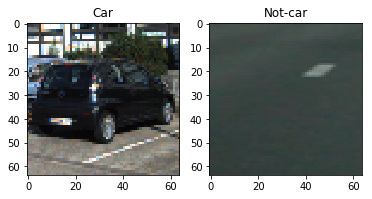

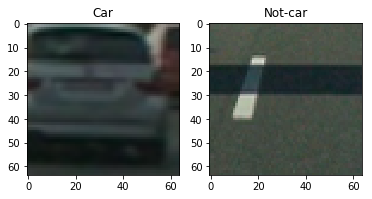

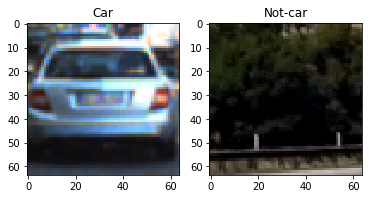

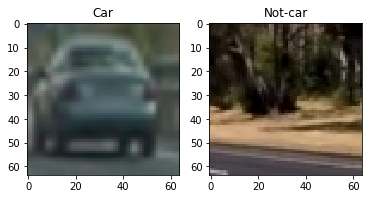

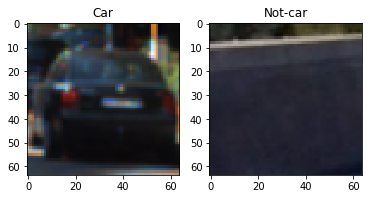

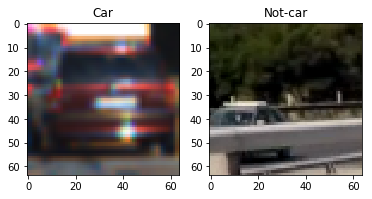

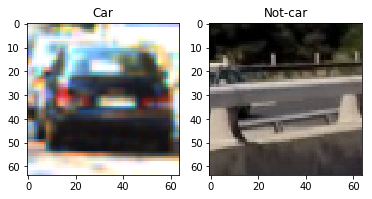

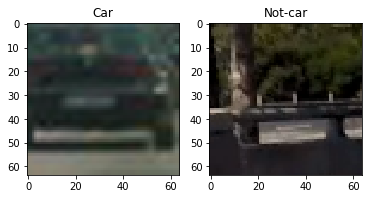

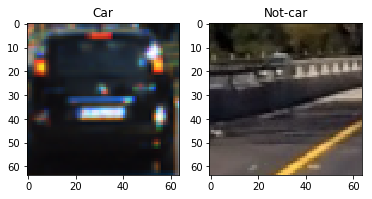

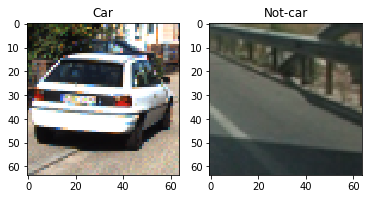

In [14]:
data_info = data_look(cars, notcars)

print('There are', data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])


for i in range(10):
    # Just for fun choose random car / not-car indices and plot example images   
    car_ind = np.random.randint(0, len(cars))
    notcar_ind = np.random.randint(0, len(notcars))
    # Read in car / not-car images
    car_image = mpimg.imread(cars[car_ind])
    notcar_image = mpimg.imread(notcars[notcar_ind])

    # Plot the examples
    fig = plt.figure()
    plt.subplot(121)
    plt.imshow(car_image)
    plt.title('Car')
    plt.subplot(122)
    plt.imshow(notcar_image)
    plt.title('Not-car')

---

## Train the SVC
* extract the features and convert it to a vstack
* make a StandardScaler, fit it to the vstack of features, and transform the vstack of features
* make an hstack of labels
* split the x and y test and training data
* make a SVC and fit it to the training data
* eveluate the SVC on the test data
* print out the SVC's preditions on several images and the actual types of the images

In [15]:
t=time.time()
car_features = extract_features(cars[:(len(cars) - 5000)], orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(notcars, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a SVC 
svc = SVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

48.81 Seconds to extract HOG features...
Using: 9 orientations 7 pixels per cell and 1 cells per block
Feature vector length: 2187
66.76 Seconds to train SVC...
Test Accuracy of SVC =  0.9843
My SVC predicts:  [ 1.  1.  0.  0.  1.  0.  1.  0.  0.  1.]
For these 10 labels:  [ 1.  1.  0.  0.  1.  0.  1.  0.  0.  1.]
0.06623 Seconds to predict 10 labels with SVC


---

## Lane finding code

The full pipeline can be found [here](https://github.com/FreedomChal/advanced_lane_detection/blob/master/P4.ipynb)

In [16]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.


# Step through the list and search for chessboard corners

def calibrate_camera(img, objpoints, imgpoints):
    _, mtx, dist, _, _ = cv2.calibrateCamera(objpoints, imgpoints, img.shape[::1], None, None)
    return mtx, dist

for fname in calibrate:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    did_ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)

    # If found, add object points, image points
    if did_ret:
        objpoints.append(objp)
        imgpoints.append(corners)

mtx, dist = calibrate_camera(gray, objpoints, imgpoints)

In [17]:
nx = 8
ny = 6

window_width = 60 
window_height = 90
margin = 100

mean1 = 0
mean2 = 0
mean3 = 0
mean4 = 0
many = 0

last_overlay = None

In [18]:
def corners_unwarp(img, nx, ny, matrix, dist, do_show = False):
    undist = img
    
    thresh1 = (65., 70.)   #S
    thresh2 = (230., 255.) #V
    thresh3 = (30., 55.)   #H
    
    gray = undist[:,:,2]
    hue = undist[:,:,0]
    thresh1 = (thresh1[0] / 255.0, thresh1[1] / 255.0)
    s_channel = undist[:,:,1]
    
    binary = np.zeros_like(s_channel)
    binary2 = np.zeros_like(s_channel)
    
    binary[((s_channel > thresh1[0]) & (s_channel <= thresh1[1])) & ((hue > thresh3[0]) & (hue <= thresh3[1]))] = 1
    binary2[((gray > thresh2[0]) & (gray <= thresh2[1]))] = 1
    
    binary += binary2 # not the issue
    binary = np.abs(cv2.Sobel(binary, cv2.CV_64F, 1, 0))
    
    binary[binary > 0.0] = 1
    
    img_size = (img.shape[1], img.shape[0])
    imsx = img_size[0]
    imsy = img_size[1]
            
    xdist = 557
    src = np.array([[0, 700], [imsx, 700], [xdist, 450], [(imsx - xdist), 450]], np.float32)
    dst = np.array([[0, imsy], [imsx, imsy], [0, 0], [imsx, 0]], np.float32)
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    
    warped = cv2.warpPerspective(binary, M, img_size)

    # Return the resulting image and matrix
    return warped

In [19]:
def find_window_centroids(warped, window_width, window_height, margin):
    last_l_center = -100
    last_r_center = -100
    warped = np.array(warped)
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones((window_width)) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(3 * warped.shape[0] / 4):,:int(warped.shape[1] / 2)], axis=0)
    l_center = np.argmax(np.convolve(window, l_sum)) - window_width / 2
    r_sum = np.sum(warped[int(3 * warped.shape[0] / 4):, int(warped.shape[1] / 2):], axis=0)
    r_center = np.argmax(np.convolve(window, r_sum)) - window_width / 2 + int(warped.shape[1] / 2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    lvl_cnt = range(0, len(window_centroids))
    for level in range(1,(int)(warped.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        
        try:  
            l_min_index = int(max(l_center+offset-margin, 0))
            l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
            l_center = np.argmax(conv_signal[l_min_index:l_max_index]) + l_min_index-offset
            # Find the best right centroid by using past right center as a reference
            r_min_index = int(max(r_center+offset-margin, 0))
            r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
            r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
            # Add what we found for that layer
        
        except:
            l_center = last_l_center
            r_center = last_r_center
            
        sensetivity = 25.
        
        sensetivity = 100. - sensetivity
        dist = last_l_center - last_r_center
        
        if ((l_center + sensetivity) < last_l_center):
            l_center = r_center + dist #last_l_center
        else:
            last_l_center = l_center
        
        if ((r_center + sensetivity) < last_r_center):
            r_center = l_center - dist #last_r_center
        else:
            last_r_center = r_center
        
        window_centroids.append((l_center, r_center))
        
    return window_centroids

In [20]:
def perspective_rewarp(img):
    img_size = (img.shape[1], img.shape[0])
    imsx = img_size[0]
    imsy = img_size[1]
    
    xdist = 557
    
    src = np.array([[0, 700], [imsx, 700], [xdist, 450], [(imsx - xdist), 450]], np.float32)
    dst = np.array([[0, imsy], [imsx, imsy], [0, 0], [imsx, 0]], np.float32)
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(dst, src)
    
    warped = cv2.warpPerspective(img, M, img_size)
    
    return warped

In [21]:
def centroids_y(window_centroids, windowsize):
    len_ = len(window_centroids)
    y_centroids = []
    for i in range(len_):
        var1 = windowsize / 2
        var2 = i * windowsize
        y_centroids.append(var1 + var2)
    return y_centroids

In [22]:
def to_lines(img, window_width, window_height, margin, do_check = False):
    global mean1
    global mean2
    global mean1
    global mean
    global many
    global last_overlay
    
    window_centroids = find_window_centroids(img, window_width, window_height, margin)

    get_side = lambda x, idx: [i[idx] for i in x]
    # Extract left and right line pixel positions
    leftx = get_side(window_centroids, 0)
    lefty = centroids_y(leftx, window_height)
    rightx = get_side(window_centroids, 1)
    righty = centroids_y(rightx, window_height)
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(np.flip(lefty, 0), leftx, 2)
    right_fit = np.polyfit(np.flip(righty, 0), rightx, 2)
    
    binary_warped = img
    
    rtnimg = np.copy(img)
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]
    
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2 * left_fit[0] * y_eval + left_fit[1]) ** 2) ** 1.5) / np.absolute(2 * left_fit[0])
    right_curverad = ((1 + (2 * right_fit[0] * y_eval + right_fit[1]) ** 2) ** 1.5) / np.absolute(2 * right_fit[0])
    
    width = img.shape[1]
    lastiteml = left_fitx[-1]
    lastitemr = right_fitx[-1]
    
    centers = window_centroids[0]
    meancenter = (centers[0] + centers[1]) / 2.
    dist =  (width / 2.) - meancenter
    ldist = (width / 2.) - lastiteml
    rdist = lastitemr - (width / 2.)
    
    rtnimg = np.array(cv2.merge((rtnimg, rtnimg, rtnimg))) * 255
    
    height = len(left_fitx)
    overlay = np.zeros_like(rtnimg)
    for y in range(height):
        left_x = int(np.round(left_fitx[y]))
        right_x = int(np.round(right_fitx[y]))
        if left_x >= 0 and left_x < width:
            overlay[y, max(left_x, 0):max(left_x + 20, 0), 2] = 125
        if right_x >= 0 and right_x < width:
            overlay[y, min(right_x - 20, width):min(right_x, width), 2] = 125
        if left_x < width and right_x > 0:
            overlay[y, max(left_x, 0):min(right_x, width), 2] = 100

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30 / 360 # meters per pixel in y dimension
    xm_per_pix = 3.7 / 700 # meters per pixel in x dimension

    if do_check:
        
        ldist2 = ldist * xm_per_pix
        rdist2 = rdist * xm_per_pix
        
        insensitive = 0.045
        if mean1 == 0:
            mean1 = ((mean1 * many) + ldist2) / (many + 1.)
            mean2 = ((mean2 * many) + rdist2) / (many + 1.)
        
        if many > 10:
            many = 10
        
        if ((np.abs(mean1 - ldist2) + np.abs(mean2 - rdist2)) < insensitive):
            last_overlay = overlay
            mean1 = ((mean1 * many) + ldist2) / (many + 1.)
            mean2 = ((mean2 * many) + rdist2) / (many + 1.)
        else:
            overlay = last_overlay
            tempmany = many + 2
            mean1 = ((mean1 * tempmany) + ldist2) / (tempmany + 1.)
            mean2 = ((mean2 * tempmany) + rdist2) / (tempmany + 1.)
        many += 1
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(np.array(lefty, np.float32)*ym_per_pix, np.array(leftx, np.float32)*xm_per_pix, 2)
    right_fit_cr = np.polyfit(np.array(righty, np.float32)*ym_per_pix, np.array(rightx, np.float32)*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2 * left_fit_cr[0] * y_eval * ym_per_pix + left_fit_cr[1]) ** 2) ** 1.5) / np.absolute(2 * left_fit_cr[0])
    right_curverad = ((1 + (2 * right_fit_cr[0] * y_eval * ym_per_pix + right_fit_cr[1]) ** 2) ** 1.5) / np.absolute(2 * right_fit_cr[0])
    # Now our radius of curvature is in meters
    puttext = "left curve radius: " + str(left_curverad)
    puttext2 = "right curve radius: " + str(right_curverad)
    puttext3 = "left dist: " + str(ldist * xm_per_pix)
    puttext4 = "right dist: " + str(rdist * xm_per_pix)
    puttext5 = "lane center dist: " + str(dist * xm_per_pix) 
    
    text = cv2.putText(np.zeros_like(overlay), puttext,(10, 25), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 3)
    text += cv2.putText(np.zeros_like(overlay), puttext2,(10, 85), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 3)
    text += cv2.putText(np.zeros_like(overlay), puttext3,(10, 55), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 3)
    text += cv2.putText(np.zeros_like(overlay), puttext4,(10, 115), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 3)
    text += cv2.putText(np.zeros_like(overlay), puttext5,(10, 145), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 150), 3)
        
    return overlay, text

In [23]:
def find_lines(img, do_check = False):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    return to_lines(corners_unwarp(img, nx, ny, mtx, dist, not do_check), window_width, window_height, margin, do_check = do_check)

In [24]:
def image_do(image):
    lines = find_lines(np.array(image, np.float32))
    rewarped = perspective_rewarp(lines[0])
    rewarped = cv2.cvtColor(rewarped.astype(np.float32), cv2.COLOR_HSV2BGR)
    rewarped2 = cv2.cvtColor(rewarped, cv2.COLOR_HSV2RGB)
    image2 = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    return np.clip((image2.astype(np.float32) + rewarped2 + lines[1]) / 255, 0., 1.)

In [25]:
def image_video(image):
    lines = find_lines(np.array(image, np.float32), do_check = True)
    rewarped = perspective_rewarp(lines[0])
    rewarped = cv2.cvtColor(rewarped.astype(np.float32), cv2.COLOR_HSV2BGR)
    rewarped2 = cv2.cvtColor(rewarped, cv2.COLOR_HSV2RGB)
    image2 = image
    
    return np.clip((image2.astype(np.float32) + rewarped2 + lines[1]), 0., 255.)

---

## drawcars_findlanes functions
### bring find_draw_cars, image_do, and image_video together

In [26]:
def drawcars_findlanes_image(image):
    cars = find_draw_cars(image, svc, is_video = False) / 255
    lanes = image_do(image) - image
    lanes[lanes < 0] = 0
    return np.clip(lanes + cars, 0., 1.)

In [27]:
def drawcars_findlanes_video(image):
    cars = find_draw_cars(image, svc, is_video = True)
    lanes = image_video(image) - image
    lanes[lanes < 0] = 0
    return np.clip(lanes + cars, 0., 255.)

---

## Go through the test images

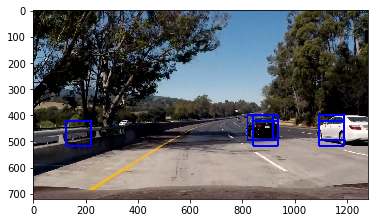

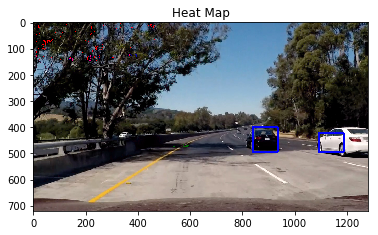

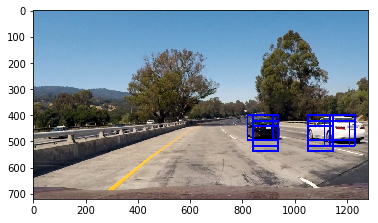

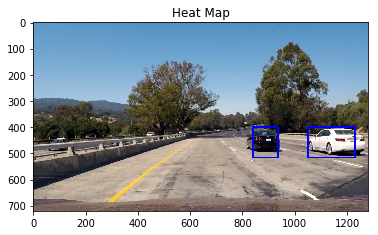

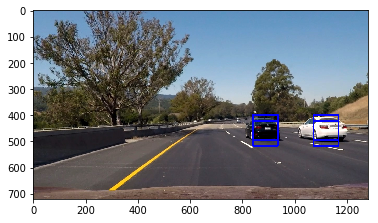

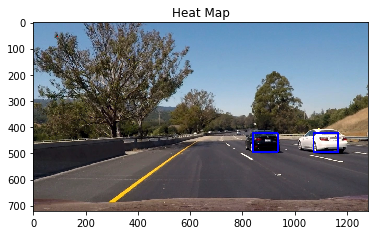

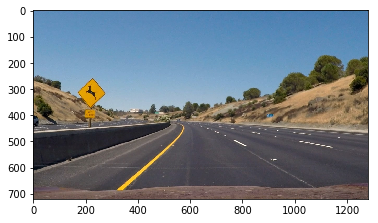

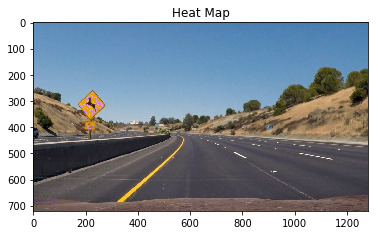

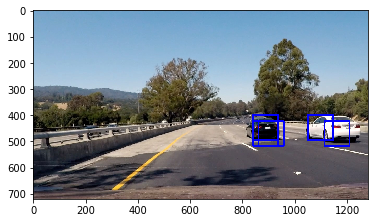

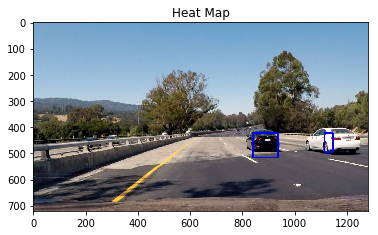

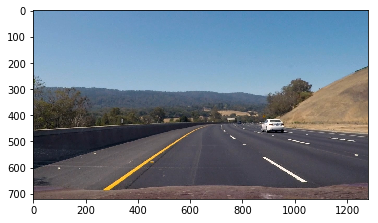

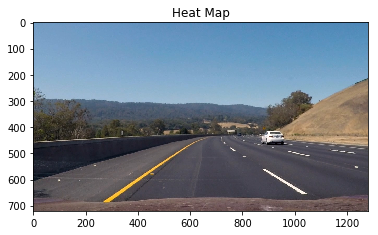

In [28]:
for file in test_images:
    image = mpimg.imread(file)
    plt.figure()
    plt.imshow(drawcars_findlanes_image(image))

---

## Run drawcars_findlanes_video on project_video.mp4

In [29]:
heatmap = None
video_output = 'output_images/project_video.mp4'
clip1 = VideoFileClip("project_video.mp4")#.subclip(0, 5.0)
white_clip = clip1.fl_image(drawcars_findlanes_video)
%time white_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video output_images/project_video.mp4
[MoviePy] Writing video output_images/project_video.mp4


100%|█████████▉| 1260/1261 [2:02:21<00:05,  5.80s/it] 


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video.mp4 

CPU times: user 2h 3min 7s, sys: 6.92 s, total: 2h 3min 14s
Wall time: 2h 2min 23s


In [30]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))